In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc, os, sys
gc.collect()

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw

    
folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values


df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.248600,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.774490,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.974570,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239


In [4]:
## load mtfs
n_up = 16
n_down = 32

folder = "/work/work_teamEXOPLANET/" 

C1 = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
C2 = np.load(folder+'/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  

C1.shape

(8054, 48, 48)

In [51]:
def distancia_matrix(A,B, tipo="frobenius"):
    if tipo=="square_sum":
        return np.mean( np.sum(np.square(A-B),axis=(1,2) ))
    elif tipo=="frobenius":
        return np.mean( np.sqrt(np.sum(np.square(A-B), axis=(1,2))) )
    elif tipo=="square_mean":
        return np.mean( np.mean(np.square(A-B),axis=(1,2) ))

In [55]:
distancia_matrix(C1, C2, tipo="frobenius")

0.3749732164650564

In [56]:
distancia_matrix(C1, C2, tipo="square_sum")

0.1540201827341675

In [57]:
distancia_matrix(C1, C2, tipo="square_mean")

6.684903764503798e-05

In [ ]:
C1 transpose vs C2??

In [107]:
df = pd.DataFrame()
C1_p_Nnoise = C1 + np.random.normal(0,1, size=C1.shape)
df["normal noise"] = [distancia_matrix(C1, C1_p_Nnoise, tipo="frobenius")]

std = C1.std(axis=(1,2))
C1_p_ScaledNnoise = C1 + std[:,None,None]*np.random.normal(0, 1, size=C1.shape)
df["normal noise fited"] = [distancia_matrix(C1, C1_p_ScaledNnoise, tipo="frobenius")]

C1_p_Unoise = C1 + np.random.uniform(0,1, size=C1.shape)
df["uniform noise"] = [distancia_matrix(C1,C1_p_Unoise , tipo="frobenius")]

C1_p_Enoise = C1 + np.random.exponential(C1.mean(), size=C1.shape)
df["exp noise"] = [distancia_matrix(C1,  C1_p_Enoise, tipo="frobenius")]

TC1 = C1.transpose([0,2,1])
df["transpose"] = [distancia_matrix(C1, TC1, tipo="frobenius")]

C1_s_C = np.roll(C1, 1, axis=1)
df["shifted 1 column"] = [distancia_matrix(C1,  C1_s_C, tipo="frobenius")]

C1_s_R = np.roll(C1, 1, axis=0)
df["shifted 1 row"] = [distancia_matrix(C1,  C1_s_R, tipo="frobenius")]

df["mirror"] = [distancia_matrix(C1, C2, tipo="frobenius")]

df

,normal noise,normal noise fited,uniform noise,exp noise,transpose,shifted 1 column,shifted 1 row,mirror
0,48.006305,1.311091,27.712456,1.414176,1.481738,0.604422,1.017195,0.374973


In [109]:
print("Probability values")
df_prob

Probability values


,normal noise,normal noise fited,uniform noise,exp noise,transpose
0,322.687891,1.479119,1.377178,0.818641,1.355288


In [108]:
df_prob = pd.DataFrame()
df_prob["normal noise"] = [distancia_matrix(C1, C1_p_Nnoise/C1_p_Nnoise.sum(axis=-1, keepdims=True), tipo="frobenius")]
df_prob["normal noise fited"] = [distancia_matrix(C1, C1_p_ScaledNnoise/C1_p_ScaledNnoise.sum(axis=-1, keepdims=True), tipo="frobenius")]
df_prob["uniform noise"] = [distancia_matrix(C1,C1_p_Unoise/C1_p_Unoise.sum(axis=-1, keepdims=True) , tipo="frobenius")]
df_prob["exp noise"] = [distancia_matrix(C1,  C1_p_Enoise/C1_p_Enoise.sum(axis=-1, keepdims=True), tipo="frobenius")]
df_prob["transpose"] = [distancia_matrix(C1, TC1/TC1.sum(axis=-1, keepdims=True), tipo="frobenius")]

df_prob

,normal noise,normal noise fited,uniform noise,exp noise,transpose
0,322.687891,1.479119,1.377178,0.818641,1.355288


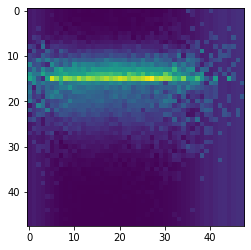

In [59]:
plt.imshow(channel_1[1].T)

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata

    
import keras, gc
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,gamma = 2,save_f='best_mod.hdf5',**args):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=gamma),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls, **args)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

Using TensorFlow backend.


In [5]:
channel_1 = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(n_up,n_down))  
channel_3 = np.load(folder+'/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(n_up,n_down))  

x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

y_train distribution: 0:2790   1:1597
y_val distribution:   0:1186   1:684
Objetos de entrenamiento: (4387, 48, 48, 2) (4387,)
Objetos de validación: (1870, 48, 48, 2) (1870,)


In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

Instructions for updating:
Use tf.cast instead.
Train on 3948 samples, validate on 439 samples
Epoch 1/200
3948/3948 [==============================] - 3s 682us/step - loss: 0.6443 - acc: 0.6365 - val_loss: 0.6762 - val_acc: 0.5285
Epoch 2/200
3948/3948 [==============================] - 3s 657us/step - loss: 0.5886 - acc: 0.6434 - val_loss: 0.5966 - val_acc: 0.6310
Epoch 3/200
3948/3948 [==============================] - 2s 572us/step - loss: 0.5614 - acc: 0.6330 - val_loss: 0.5831 - val_acc: 0.6310
Epoch 4/200
3948/3948 [==============================] - 2s 609us/step - loss: 0.5483 - acc: 0.6340 - val_loss: 0.5803 - val_acc: 0.5285
Epoch 5/200
3948/3948 [==============================] - 3s 667us/step - loss: 0.5419 - acc: 0.6236 - val_loss: 0.5725 - val_acc: 0.5626
Epoch 6/200
3948/3948 [==============================] - 2s 629us/step - loss: 0.5396 - acc: 0.6418 - val_loss: 0.5692 - val_acc: 0.5285
Epoch 7/200
3948/3948 [==============================] - 2s 579us/step - loss: 0.53

Epoch 34/200
3948/3948 [==============================] - 2s 565us/step - loss: 0.5117 - acc: 0.6819 - val_loss: 0.5765 - val_acc: 0.6059
Epoch 35/200
3948/3948 [==============================] - 2s 546us/step - loss: 0.5062 - acc: 0.6930 - val_loss: 0.5943 - val_acc: 0.5809
Epoch 36/200
3948/3948 [==============================] - 2s 552us/step - loss: 0.5045 - acc: 0.6955 - val_loss: 0.5802 - val_acc: 0.6036
Epoch 37/200
3948/3948 [==============================] - 2s 570us/step - loss: 0.5067 - acc: 0.6938 - val_loss: 0.5784 - val_acc: 0.6105
Epoch 38/200
3948/3948 [==============================] - 2s 560us/step - loss: 0.5024 - acc: 0.6940 - val_loss: 0.5820 - val_acc: 0.5831
Epoch 39/200
3948/3948 [==============================] - 2s 556us/step - loss: 0.5063 - acc: 0.6968 - val_loss: 0.5794 - val_acc: 0.6219
Epoch 40/200
3948/3948 [==============================] - 2s 556us/step - loss: 0.5035 - acc: 0.6966 - val_loss: 0.5655 - val_acc: 0.6446
Epoch 41/200
3948/3948 [==========

3948/3948 [==============================] - 2s 580us/step - loss: 0.4662 - acc: 0.7315 - val_loss: 0.5359 - val_acc: 0.6743
Epoch 103/200
3948/3948 [==============================] - 2s 553us/step - loss: 0.4607 - acc: 0.7280 - val_loss: 0.5494 - val_acc: 0.6606
Epoch 104/200
3948/3948 [==============================] - 2s 547us/step - loss: 0.4634 - acc: 0.7335 - val_loss: 0.5483 - val_acc: 0.6788
Epoch 105/200
3948/3948 [==============================] - 2s 553us/step - loss: 0.4664 - acc: 0.7280 - val_loss: 0.5512 - val_acc: 0.6515
Epoch 106/200
3948/3948 [==============================] - 2s 565us/step - loss: 0.4632 - acc: 0.7340 - val_loss: 0.5544 - val_acc: 0.6492
Epoch 107/200
3948/3948 [==============================] - 2s 537us/step - loss: 0.4609 - acc: 0.7330 - val_loss: 0.5306 - val_acc: 0.7289
Epoch 108/200
3948/3948 [==============================] - 2s 544us/step - loss: 0.4631 - acc: 0.7343 - val_loss: 0.5205 - val_acc: 0.7062
Epoch 109/200
3948/3948 [================

3948/3948 [==============================] - 2s 557us/step - loss: 0.4500 - acc: 0.7409 - val_loss: 0.5372 - val_acc: 0.6902
Epoch 137/200
3948/3948 [==============================] - 2s 553us/step - loss: 0.4485 - acc: 0.7394 - val_loss: 0.5462 - val_acc: 0.6720
Epoch 138/200
3948/3948 [==============================] - 2s 578us/step - loss: 0.4501 - acc: 0.7376 - val_loss: 0.5333 - val_acc: 0.6902
Epoch 139/200
3948/3948 [==============================] - 2s 574us/step - loss: 0.4489 - acc: 0.7442 - val_loss: 0.5625 - val_acc: 0.6811
Epoch 140/200
3948/3948 [==============================] - 2s 558us/step - loss: 0.4498 - acc: 0.7530 - val_loss: 0.5418 - val_acc: 0.6879
Epoch 141/200
3948/3948 [==============================] - 2s 562us/step - loss: 0.4469 - acc: 0.7429 - val_loss: 0.5531 - val_acc: 0.6560
Epoch 142/200
3948/3948 [==============================] - 2s 561us/step - loss: 0.4402 - acc: 0.7523 - val_loss: 0.5719 - val_acc: 0.6720
Epoch 143/200
3948/3948 [================

3948/3948 [==============================] - 2s 563us/step - loss: 0.4288 - acc: 0.7599 - val_loss: 0.5791 - val_acc: 0.6765
Epoch 171/200
3948/3948 [==============================] - 2s 590us/step - loss: 0.4306 - acc: 0.7556 - val_loss: 0.5864 - val_acc: 0.6674
Epoch 172/200
3948/3948 [==============================] - 2s 572us/step - loss: 0.4353 - acc: 0.7601 - val_loss: 0.5851 - val_acc: 0.6469
Epoch 173/200
3948/3948 [==============================] - 2s 544us/step - loss: 0.4299 - acc: 0.7606 - val_loss: 0.5659 - val_acc: 0.6765
Epoch 174/200
3948/3948 [==============================] - 2s 539us/step - loss: 0.4275 - acc: 0.7617 - val_loss: 0.5556 - val_acc: 0.6856
Epoch 175/200
3948/3948 [==============================] - 2s 558us/step - loss: 0.4302 - acc: 0.7576 - val_loss: 0.5642 - val_acc: 0.6834
Epoch 176/200
3948/3948 [==============================] - 2s 555us/step - loss: 0.4326 - acc: 0.7492 - val_loss: 0.5679 - val_acc: 0.6879
Epoch 177/200
3948/3948 [================

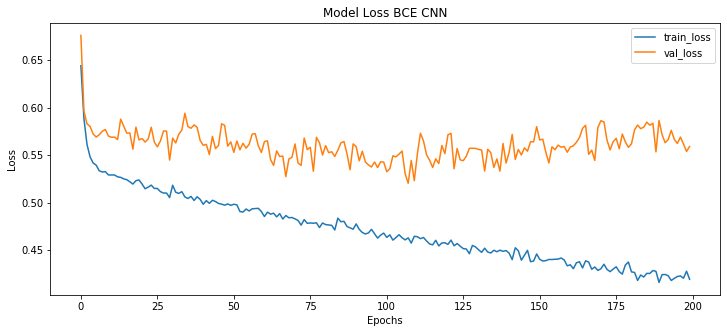

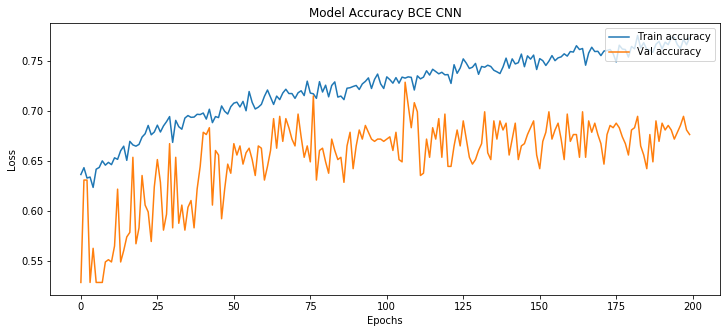

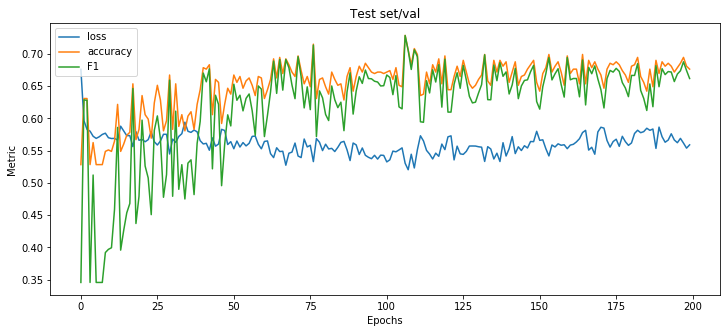

In [7]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='models/NOAUG_16u_32d_N.h5') 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.841996,0.682968,0.754190,0.722789,0.711266,0.717647
Confirmed,0.585903,0.777778,0.668342,0.722789,0.711266,0.717647


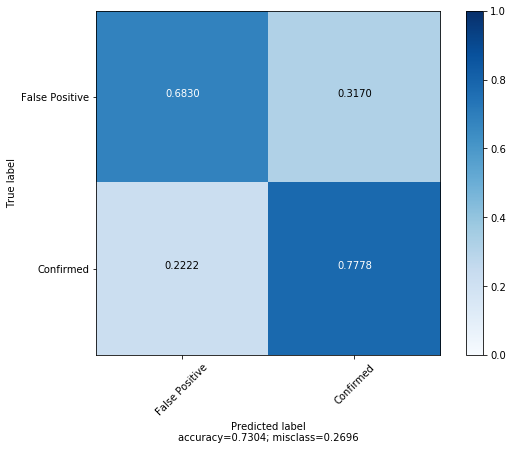

{'Precision raw': array([0.84199584, 0.58590308]),
 'Recall raw': array([0.68296796, 0.77777778]),
 'F1 raw': array([0.75418994, 0.66834171]),
 'F1 weighted': 0.7227887713295362,
 'F1 macro': 0.711265826338396,
 'F1 micro': 0.7176470588235294,
 'Confusion Matrix': array([[810, 376],
        [152, 532]])}

In [8]:
model = keras.models.load_model("models/NOAUG_16u_32d_N.h5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

Train on 3948 samples, validate on 439 samples
Epoch 1/200
3948/3948 [==============================] - 3s 837us/step - loss: 0.6476 - acc: 0.6383 - val_loss: 0.6797 - val_acc: 0.5285
Epoch 2/200
3948/3948 [==============================] - 2s 592us/step - loss: 0.5936 - acc: 0.6479 - val_loss: 0.5923 - val_acc: 0.6469
Epoch 3/200
3948/3948 [==============================] - 2s 610us/step - loss: 0.5642 - acc: 0.6320 - val_loss: 0.5790 - val_acc: 0.6651
Epoch 4/200
3948/3948 [==============================] - 3s 659us/step - loss: 0.5524 - acc: 0.6355 - val_loss: 0.5746 - val_acc: 0.6765
Epoch 5/200
3948/3948 [==============================] - 2s 605us/step - loss: 0.5469 - acc: 0.6393 - val_loss: 0.5758 - val_acc: 0.5695
Epoch 6/200
3948/3948 [==============================] - 2s 602us/step - loss: 0.5393 - acc: 0.6413 - val_loss: 0.5838 - val_acc: 0.5308
Epoch 7/200
3948/3948 [==============================] - 2s 566us/step - loss: 0.5382 - acc: 0.6378 - val_loss: 0.5723 - val_acc: 0

Epoch 35/200
3948/3948 [==============================] - 2s 580us/step - loss: 0.5055 - acc: 0.6907 - val_loss: 0.5703 - val_acc: 0.5923
Epoch 36/200
3948/3948 [==============================] - 2s 578us/step - loss: 0.4999 - acc: 0.7019 - val_loss: 0.5843 - val_acc: 0.5923
Epoch 37/200
3948/3948 [==============================] - 2s 632us/step - loss: 0.5013 - acc: 0.6938 - val_loss: 0.5647 - val_acc: 0.6219
Epoch 38/200
3948/3948 [==============================] - 2s 609us/step - loss: 0.5016 - acc: 0.6983 - val_loss: 0.5516 - val_acc: 0.6651
Epoch 39/200
3948/3948 [==============================] - 2s 595us/step - loss: 0.5003 - acc: 0.7026 - val_loss: 0.5765 - val_acc: 0.6583
Epoch 40/200
3948/3948 [==============================] - 2s 580us/step - loss: 0.4998 - acc: 0.7016 - val_loss: 0.5505 - val_acc: 0.6674
Epoch 41/200
3948/3948 [==============================] - 2s 565us/step - loss: 0.4999 - acc: 0.7067 - val_loss: 0.5793 - val_acc: 0.6014
Epoch 42/200
3948/3948 [==========

3948/3948 [==============================] - 2s 544us/step - loss: 0.4676 - acc: 0.7224 - val_loss: 0.5301 - val_acc: 0.6811
Epoch 104/200
3948/3948 [==============================] - 2s 550us/step - loss: 0.4631 - acc: 0.7307 - val_loss: 0.5486 - val_acc: 0.6651
Epoch 105/200
3948/3948 [==============================] - 2s 547us/step - loss: 0.4621 - acc: 0.7348 - val_loss: 0.5577 - val_acc: 0.6515
Epoch 106/200
3948/3948 [==============================] - 2s 563us/step - loss: 0.4667 - acc: 0.7323 - val_loss: 0.5262 - val_acc: 0.6811
Epoch 107/200
3948/3948 [==============================] - 2s 564us/step - loss: 0.4629 - acc: 0.7345 - val_loss: 0.5544 - val_acc: 0.6651
Epoch 108/200
3948/3948 [==============================] - 2s 567us/step - loss: 0.4676 - acc: 0.7285 - val_loss: 0.5476 - val_acc: 0.6697
Epoch 109/200
3948/3948 [==============================] - 2s 563us/step - loss: 0.4645 - acc: 0.7363 - val_loss: 0.5479 - val_acc: 0.6560
Epoch 110/200
3948/3948 [================

3948/3948 [==============================] - 2s 567us/step - loss: 0.4490 - acc: 0.7432 - val_loss: 0.5405 - val_acc: 0.6856
Epoch 138/200
3948/3948 [==============================] - 2s 532us/step - loss: 0.4458 - acc: 0.7470 - val_loss: 0.5565 - val_acc: 0.6651
Epoch 139/200
3948/3948 [==============================] - 2s 551us/step - loss: 0.4456 - acc: 0.7490 - val_loss: 0.5534 - val_acc: 0.6720
Epoch 140/200
3948/3948 [==============================] - 2s 575us/step - loss: 0.4455 - acc: 0.7538 - val_loss: 0.5330 - val_acc: 0.7039
Epoch 141/200
3948/3948 [==============================] - 2s 572us/step - loss: 0.4473 - acc: 0.7503 - val_loss: 0.5499 - val_acc: 0.6674
Epoch 142/200
3948/3948 [==============================] - 2s 611us/step - loss: 0.4432 - acc: 0.7503 - val_loss: 0.5626 - val_acc: 0.6674
Epoch 143/200
3948/3948 [==============================] - 2s 594us/step - loss: 0.4463 - acc: 0.7467 - val_loss: 0.5485 - val_acc: 0.6765
Epoch 144/200
3948/3948 [================

3948/3948 [==============================] - 2s 545us/step - loss: 0.4304 - acc: 0.7622 - val_loss: 0.5606 - val_acc: 0.6743
Epoch 172/200
3948/3948 [==============================] - 2s 539us/step - loss: 0.4290 - acc: 0.7677 - val_loss: 0.5621 - val_acc: 0.6629
Epoch 173/200
3948/3948 [==============================] - 2s 545us/step - loss: 0.4296 - acc: 0.7553 - val_loss: 0.5769 - val_acc: 0.6606
Epoch 174/200
3948/3948 [==============================] - 2s 546us/step - loss: 0.4365 - acc: 0.7518 - val_loss: 0.5730 - val_acc: 0.6629
Epoch 175/200
3948/3948 [==============================] - 2s 559us/step - loss: 0.4304 - acc: 0.7647 - val_loss: 0.5635 - val_acc: 0.7107
Epoch 176/200
3948/3948 [==============================] - 2s 547us/step - loss: 0.4221 - acc: 0.7680 - val_loss: 0.6018 - val_acc: 0.6583
Epoch 177/200
3948/3948 [==============================] - 2s 543us/step - loss: 0.4228 - acc: 0.7634 - val_loss: 0.5668 - val_acc: 0.6879
Epoch 178/200
3948/3948 [================

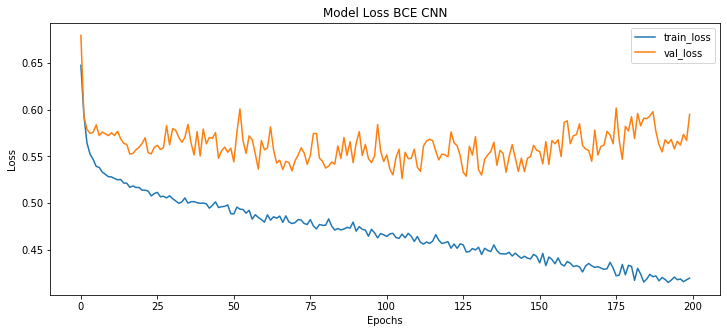

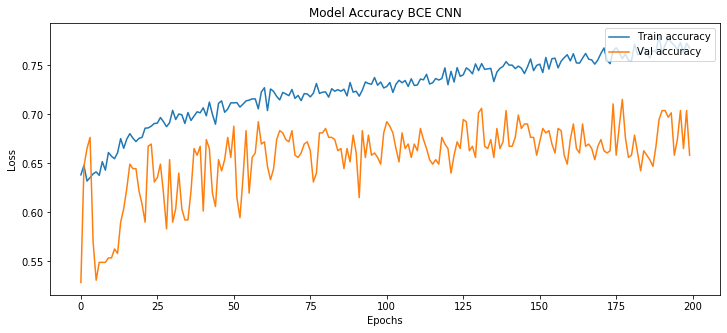

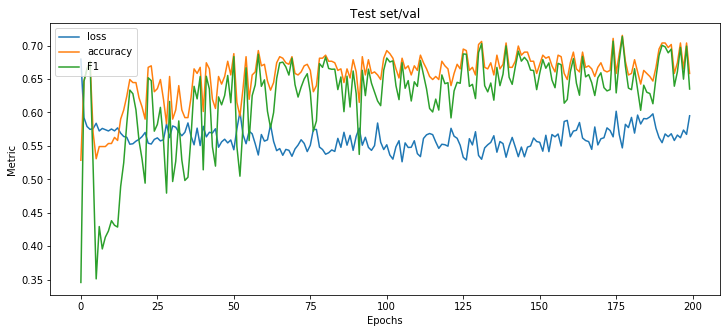

In [11]:
from sklearn.utils import class_weight

# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, save_f='models/NOAUG_16u_32d_CW.h5', class_weight=weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.790017,0.774030,0.781942,0.727164,0.707063,0.726203
Confirmed,0.621469,0.643275,0.632184,0.727164,0.707063,0.726203


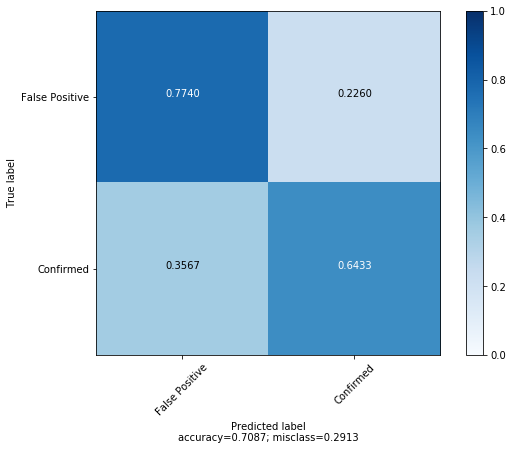

{'Precision raw': array([0.79001721, 0.62146893]),
 'Recall raw': array([0.77403035, 0.64327485]),
 'F1 raw': array([0.78194208, 0.63218391]),
 'F1 weighted': 0.7271642235528466,
 'F1 macro': 0.7070629932052713,
 'F1 micro': 0.7262032085561498,
 'Confusion Matrix': array([[918, 268],
        [244, 440]])}

In [12]:
model = keras.models.load_model("models/NOAUG_16u_32d_CW.h5")
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double